In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
ticker_symbol = "AAPL"
stock_data = yf.download(ticker_symbol, start="2022-01-01", end="2024-01-01")
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.481110,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,177.203186,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,172.489624,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,169.610199,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,169.777832,86709100
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


In [3]:
stock_data['Simple Return'] = stock_data['Adj Close'].pct_change()
stock_data['Log Return'] = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))
stock_data['Realised Vol'] = stock_data['Log Return'].rolling(22).std()

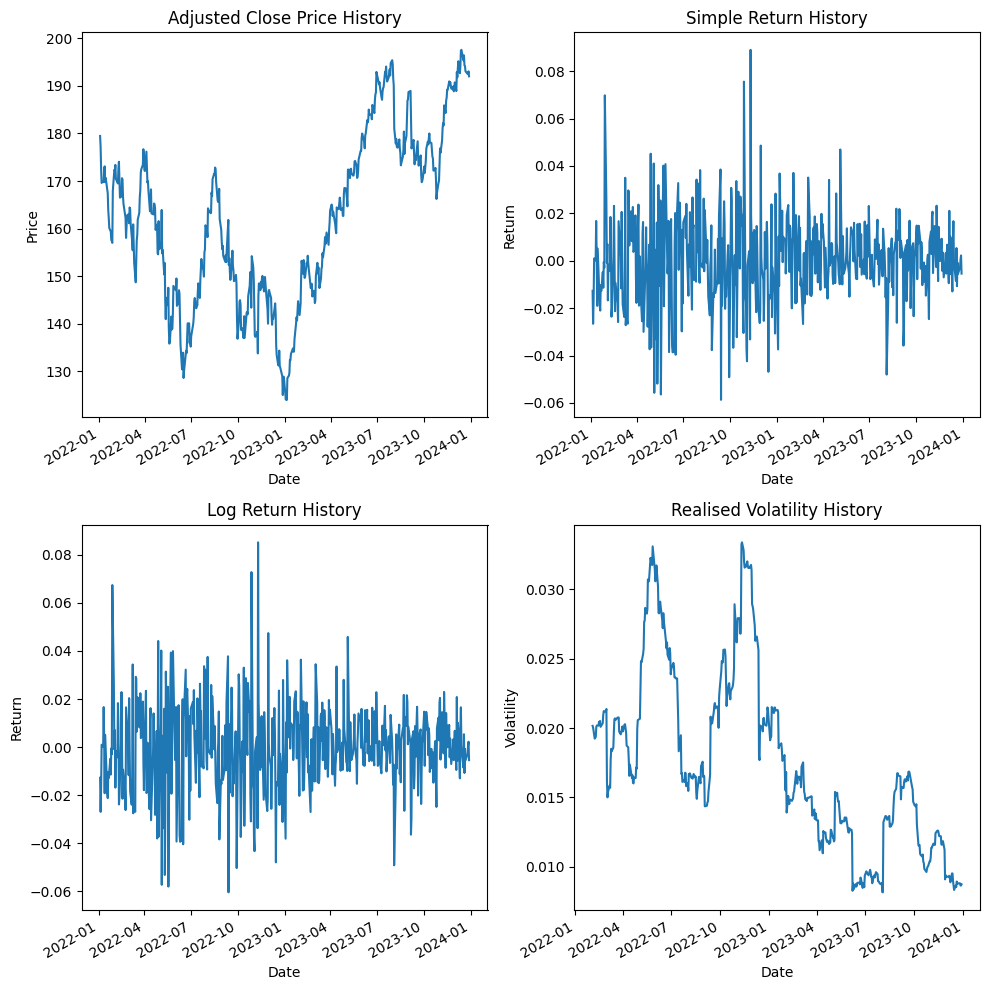

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
stock_data['Adj Close'].plot(ax=ax[0,0])
stock_data['Simple Return'].plot(ax=ax[0,1])
stock_data['Log Return'].plot(ax=ax[1,0])
stock_data['Realised Vol'].plot(ax=ax[1,1])

ax[0, 0].set_title("Adjusted Close Price History")
ax[0, 1].set_title("Simple Return History")
ax[1, 0].set_title("Log Return History")
ax[1, 1].set_title("Realised Volatility History")

ax[0, 0].set_ylabel("Price")
ax[0, 1].set_ylabel("Return")
ax[1, 0].set_ylabel("Return")
ax[1, 1].set_ylabel("Volatility")

plt.tight_layout()
plt.show()

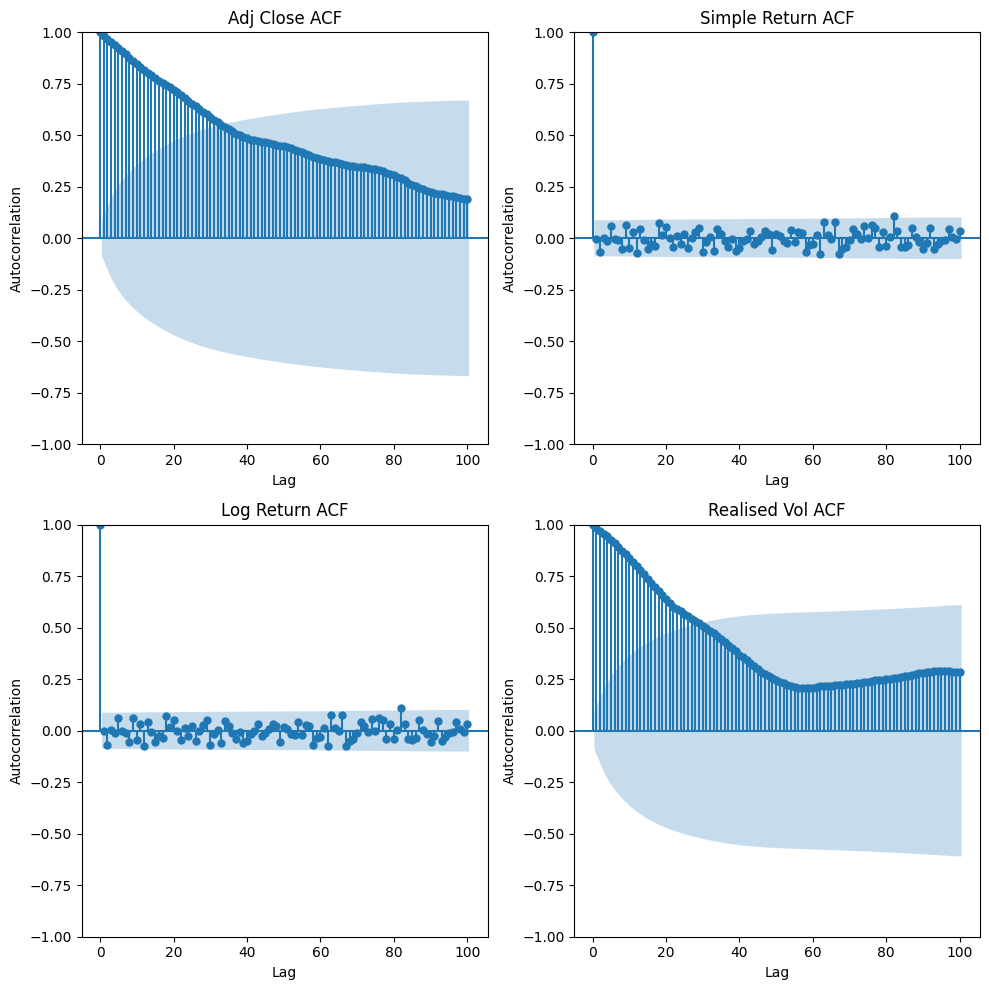

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

plot_acf(stock_data['Adj Close'], lags=100, ax=ax[0, 0])
plot_acf(stock_data['Simple Return'].dropna(), lags=100, ax=ax[0, 1])
plot_acf(stock_data['Log Return'].dropna(), lags=100, ax=ax[1, 0])
plot_acf(stock_data['Realised Vol'].dropna(), lags=100, ax=ax[1, 1])

ax[0, 0].set_title("Adj Close ACF")
ax[0, 0].set_xlabel("Lag")
ax[0, 0].set_ylabel("Autocorrelation")
ax[0, 1].set_title("Simple Return ACF")
ax[0, 1].set_xlabel("Lag")
ax[0, 1].set_ylabel("Autocorrelation")
ax[1, 0].set_title("Log Return ACF")
ax[1, 0].set_xlabel("Lag")
ax[1, 0].set_ylabel("Autocorrelation")
ax[1, 1].set_title("Realised Vol ACF")
ax[1, 1].set_xlabel("Lag")
ax[1, 1].set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()

In [6]:
from scipy.optimize import least_squares, minimize, LinearConstraint, NonlinearConstraint, BFGS, SR1
import scipy.optimize as scopt
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets
from scipy.stats import norm
import jax.numpy as jnp
import jax.random as jrd
from jax import jit, value_and_grad, jacrev
import jax
from functools import partial
import pandas as pd
import yfinance as yf

In [7]:
class Stage6Algorithm():
  def __init__(self, num_features, ar_order):
    self.num_features, self.ar_order = num_features, ar_order
    self.X, self.G, self.S, self.K = None, None, None, None
    self.dims = None

  def objective(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)

    lg, ls, lx = 1, 1, 1
    objective_value = lg * np.linalg.norm(G) ** 2 + ls * np.linalg.norm(S, 1)

    return objective_value

  def hankel_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, K_t = params[:X_len], params[X_len+G_len+S_len:]
    X, K_t = X.reshape(X_shape), K_t.reshape(K_shape)
    K = self.K
    K[-self.num_features:] = K_t

    X1, X2 = X[:, :-1], X[:, 1:]
    X1, X2 = X1[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1), X2[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1)
    return (X2 - K @ X1).flatten()

  def D_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)
    return (self.D - X - G - S).flatten()
    
  def fit(self, D, bounds=None, retrain=False):
    if retrain:
      print("Using learned parameters")
      len_diff = D.shape[1] - self.X.shape[1]
      if len_diff == 0:
        X_initial_guess = self.X
      else:
        X_initial_guess = np.hstack((self.X, self.forecast(self.X, len_diff)))
      G_initial_guess, S_initial_guess, K_initial_guess = \
        np.hstack((self.G, np.zeros((D.shape[0], len_diff)))), np.hstack((self.S, np.zeros((D.shape[0], len_diff)))), self.K
    else:
      print("Learning from scratch")
      X_initial_guess, G_initial_guess, S_initial_guess, K_initial_guess = \
        D, np.random.normal(0, 0.01, D.shape), np.random.standard_t(3, D.shape) / 100, np.zeros((self.num_features, self.num_features*self.ar_order))

    min_val, max_val = D.min(axis=1).reshape(-1, 1), D.max(axis=1).reshape(-1, 1)
    self.min_val, self.max_val = min_val, max_val

    D = (D - min_val) / (max_val - min_val)
    X_initial_guess = (X_initial_guess - min_val) / (max_val - min_val)
    G_initial_guess = G_initial_guess / (max_val - min_val)
    S_initial_guess = S_initial_guess / (max_val - min_val)

    params = np.concatenate([X_initial_guess.flatten(), G_initial_guess.flatten(), S_initial_guess.flatten(), K_initial_guess.flatten()])
    dims = (
      (X_initial_guess.shape, len(X_initial_guess.flatten())),
      (G_initial_guess.shape, len(G_initial_guess.flatten())),
      (S_initial_guess.shape, len(S_initial_guess.flatten())),
      (K_initial_guess.shape, len(K_initial_guess.flatten()))
    )
    self.dims = dims

    self.D = D
    self.idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(D.shape[1] - self.ar_order)).ravel()

    K = np.zeros((self.num_features * self.ar_order, self.num_features * self.ar_order))
    rows, cols = np.diag_indices(self.num_features * self.ar_order - self.num_features)
    K[rows, cols + self.num_features] = 1
    self.K = K

    hankel_constraint = NonlinearConstraint(self.hankel_constraint, 0, 0)
    D_constraint = NonlinearConstraint(self.D_constraint, 0, 0)

    # constraints = (
    #   {'type': 'eq', 'fun': self.hankel_constraint, 'args': (K, dims[0][0], dims[0][1], dims[1][1], dims[2][1], dims[3][0], idx_ravel)},
    #   {'type': 'eq', 'fun': self.D_constraint, 'args': (D, dims[0][0], dims[0][1], dims[1][0], dims[1][1], dims[2][0], dims[2][1])},
    # )
    constraints = [hankel_constraint, D_constraint]

    options = {
      'disp': True,
      'maxiter': 1000,
      'gtol': 1e-6,
      'xtol': 1e-6
    }

    # obj_and_grad = jit(value_and_grad(self.objective))
    result = minimize(self.objective, params, method='trust-constr', constraints=constraints, options=options, jac='2-point', hess=BFGS())

    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S, K = result.x[:X_len], result.x[X_len:X_len+G_len], result.x[X_len+G_len:X_len+G_len+S_len], result.x[X_len+G_len+S_len:]
    X, G, S, K = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape), K.reshape(K_shape)

    X, G, S = X * (max_val - min_val) + min_val, G * (max_val - min_val), S * (max_val - min_val)
    self.X, self.G, self.S, self.K = X, G, S, K

  def forecast(self, x, timesteps):
    x = (x - self.min_val) / (self.max_val - self.min_val)
    current_window = x[:, -(self.ar_order+self.num_features)+1:]
    forecasted = np.zeros((self.num_features, timesteps))
    idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(current_window.shape[1] - self.ar_order + 1)).ravel()
    for i in range(timesteps):
      hankel_window = current_window[:, idx_ravel].reshape(self.num_features * self.ar_order, -1)
      next_el = (self.K @ hankel_window)[:, -1]
      forecasted[:, i] = next_el
      current_window = np.hstack((current_window, next_el.reshape(-1, 1)))[:, 1:]
    forecasted = forecasted * (self.max_val - self.min_val) + self.min_val
    return forecasted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

In [8]:
ticker_symbol = ["MSFT", "AAPL", "GOOG"]
stock_data = yf.download(ticker_symbol, start="2022-01-01", end="2024-01-01")
stock_data

[*********************100%%**********************]  3 of 3 completed


Price        Adj Close                               Close              \
Ticker            AAPL        GOOG        MSFT        AAPL        GOOG   
Date                                                                     
2022-01-03  179.481110  145.074493  327.530121  182.009995  145.074493   
2022-01-04  177.203186  144.416504  321.913910  179.699997  144.416504   
2022-01-05  172.489624  137.653503  309.556335  174.919998  137.653503   
2022-01-06  169.610199  137.550995  307.110199  172.000000  137.550995   
2022-01-07  169.777832  137.004501  307.266785  172.169998  137.004501   
...                ...         ...         ...         ...         ...   
2023-12-22  193.091385  142.720001  373.215393  193.600006  142.720001   
2023-12-26  192.542831  142.820007  373.295135  193.050003  142.820007   
2023-12-27  192.642548  141.440002  372.707275  193.149994  141.440002   
2023-12-28  193.071426  141.279999  373.912842  193.580002  141.279999   
2023-12-29  192.024185  140.929993  374.670074  192.529999  140.929993   

Price                         High                                 Low  \
Ticker            MSFT        AAPL        GOOG        MSFT        AAPL   
Date                                                                     
2022-01-03  334.750000  182.880005  145.550003  338.000000  177.710007   
2022-01-04  329.010010  182.940002  146.610001  335.200012  179.119995   
2022-01-05  316.380005  180.169998  144.298004  326.070007  174.639999   
2022-01-06  313.880005  175.300003  139.686005  318.700012  171.639999   
2022-01-07  314.040009  174.139999  138.254745  316.500000  171.029999   
...                ...         ...         ...         ...         ...   
2023-12-22  374.579987  195.410004  143.250000  375.179993  192.970001   
2023-12-26  374.660004  193.889999  143.945007  376.940002  192.830002   
2023-12-27  374.070007  193.500000  143.320007  375.059998  191.089996   
2023-12-28  375.279999  194.660004  142.270004  376.459991  193.169998   
2023-12-29  376.040009  194.399994  141.434998  377.160004  191.729996   

Price                                     Open                          \
Ticker            GOOG        MSFT        AAPL        GOOG        MSFT   
Date                                                                     
2022-01-03  143.502502  329.779999  177.830002  144.475494  335.350006   
2022-01-04  143.816147  326.119995  182.630005  145.550507  334.829987   
2022-01-05  137.523499  315.980011  179.610001  144.181000  325.859985   
2022-01-06  136.763504  311.489990  172.699997  137.497498  313.149994   
2022-01-07  135.789001  310.089996  172.889999  137.904999  314.149994   
...                ...         ...         ...         ...         ...   
2023-12-22  142.054993  372.709991  195.179993  142.130005  373.679993   
2023-12-26  142.500000  373.500000  193.610001  142.979996  375.000000   
2023-12-27  141.050995  372.809998  192.490005  142.830002  373.690002   
2023-12-28  140.828003  374.160004  194.139999  141.850006  375.369995   
2023-12-29  139.899994  373.480011  193.899994  140.679993  376.000000   

Price          Volume                      
Ticker           AAPL      GOOG      MSFT  
Date                                       
2022-01-03  104487900  25214000  28865100  
2022-01-04   99310400  22928000  32674300  
2022-01-05   94537600  49642000  40054300  
2022-01-06   96904000  29050000  39646100  
2022-01-07   86709100  19408000  32720000  
...               ...       ...       ...  
2023-12-22   37122800  18494700  17091100  
2023-12-26   28919300  11170100  12673100  
2023-12-27   48087700  17288400  14905400  
2023-12-28   34049900  12192500  14327000  
2023-12-29   42628800  14872700  18723000  

[501 rows x 18 columns]

In [9]:
for ticker in ticker_symbol:
  stock_data['Simple Return', ticker] = stock_data['Adj Close', ticker].pct_change()
  stock_data['Log Return', ticker] = np.log(stock_data['Adj Close', ticker] / stock_data['Adj Close', ticker].shift(1))
  stock_data['Realised Vol', ticker] = stock_data['Log Return', ticker].rolling(22).std()

In [10]:
stock_data

Price        Adj Close                               Close              \
Ticker            AAPL        GOOG        MSFT        AAPL        GOOG   
Date                                                                     
2022-01-03  179.481110  145.074493  327.530121  182.009995  145.074493   
2022-01-04  177.203186  144.416504  321.913910  179.699997  144.416504   
2022-01-05  172.489624  137.653503  309.556335  174.919998  137.653503   
2022-01-06  169.610199  137.550995  307.110199  172.000000  137.550995   
2022-01-07  169.777832  137.004501  307.266785  172.169998  137.004501   
...                ...         ...         ...         ...         ...   
2023-12-22  193.091385  142.720001  373.215393  193.600006  142.720001   
2023-12-26  192.542831  142.820007  373.295135  193.050003  142.820007   
2023-12-27  192.642548  141.440002  372.707275  193.149994  141.440002   
2023-12-28  193.071426  141.279999  373.912842  193.580002  141.279999   
2023-12-29  192.024185  140.929993  374.670074  192.529999  140.929993   

Price                         High                                 Low  ...  \
Ticker            MSFT        AAPL        GOOG        MSFT        AAPL  ...   
Date                                                                    ...   
2022-01-03  334.750000  182.880005  145.550003  338.000000  177.710007  ...   
2022-01-04  329.010010  182.940002  146.610001  335.200012  179.119995  ...   
2022-01-05  316.380005  180.169998  144.298004  326.070007  174.639999  ...   
2022-01-06  313.880005  175.300003  139.686005  318.700012  171.639999  ...   
2022-01-07  314.040009  174.139999  138.254745  316.500000  171.029999  ...   
...                ...         ...         ...         ...         ...  ...   
2023-12-22  374.579987  195.410004  143.250000  375.179993  192.970001  ...   
2023-12-26  374.660004  193.889999  143.945007  376.940002  192.830002  ...   
2023-12-27  374.070007  193.500000  143.320007  375.059998  191.089996  ...   
2023-12-28  375.279999  194.660004  142.270004  376.459991  193.169998  ...   
2023-12-29  376.040009  194.399994  141.434998  377.160004  191.729996  ...   

Price         Volume Simple Return Log Return Realised Vol Simple Return  \
Ticker          MSFT          MSFT       MSFT         MSFT          AAPL   
Date                                                                       
2022-01-03  28865100           NaN        NaN          NaN           NaN   
2022-01-04  32674300     -0.017147  -0.017296          NaN     -0.012692   
2022-01-05  40054300     -0.038388  -0.039144          NaN     -0.026600   
2022-01-06  39646100     -0.007902  -0.007933          NaN     -0.016693   
2022-01-07  32720000      0.000510   0.000510          NaN      0.000988   
...              ...           ...        ...          ...           ...   
2023-12-22  17091100      0.002784   0.002780     0.009757     -0.005547   
2023-12-26  12673100      0.000214   0.000214     0.009346     -0.002841   
2023-12-27  14905400     -0.001575  -0.001576     0.009349      0.000518   
2023-12-28  14327000      0.003235   0.003229     0.009351      0.002226   
2023-12-29  18723000      0.002025   0.002023     0.009035     -0.005424   

Price      Log Return Realised Vol Simple Return Log Return Realised Vol  
Ticker           AAPL         AAPL          GOOG       GOOG         GOOG  
Date                                                                      
2022-01-03        NaN          NaN           NaN        NaN          NaN  
2022-01-04  -0.012773          NaN     -0.004536  -0.004546          NaN  
2022-01-05  -0.026960          NaN     -0.046830  -0.047962          NaN  
2022-01-06  -0.016834          NaN     -0.000745  -0.000745          NaN  
2022-01-07   0.000988          NaN     -0.003973  -0.003981          NaN  
...               ...          ...           ...        ...          ...  
2023-12-22  -0.005563     0.008792      0.006488   0.006467     0.016587  
2023-12-26  -0.002845     0.008799      0

In [11]:
stock_data['Adj Close'].dropna().to_numpy().shape

(501, 3)

Learning from scratch


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


KeyboardInterrupt: 

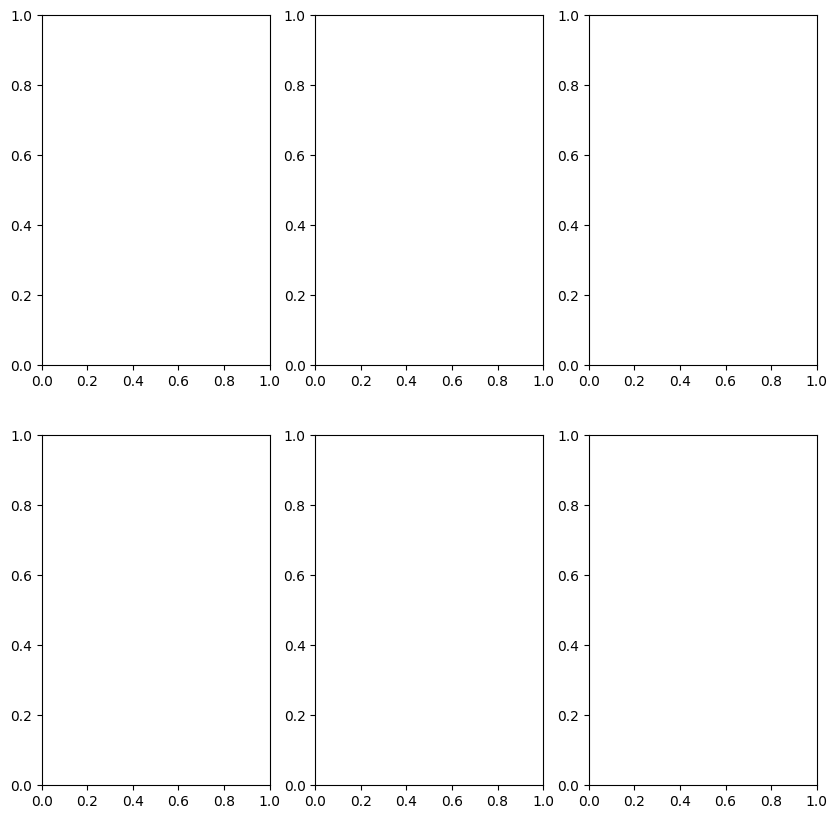

In [12]:
order, test_len = 1, 21

datasets = [
  ("Adjusted Close", stock_data['Adj Close'].dropna().to_numpy().T),
  ("Volatility", stock_data['Realised Vol'].dropna().to_numpy().T),
]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))

for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage6Algorithm(num_features=train_data.shape[0], ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i % 2, 0].plot(range(train_data.shape[1]), train_data[0], label="True Train")
  ax[i % 2, 1].plot(range(train_data.shape[1]), train_data[1], label="True Train")
  ax[i % 2, 2].plot(range(train_data.shape[1]), train_data[2], label="True Train")

  ax[i % 2, 0].plot(range(train_data.shape[1]), fitted[0], label="Fitted")
  ax[i % 2, 1].plot(range(train_data.shape[1]), fitted[1], label="Fitted")
  ax[i % 2, 2].plot(range(train_data.shape[1]), fitted[2], label="Fitted")

  ax[i % 2, 0].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data[0], label="True Test")
  ax[i % 2, 1].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data[1], label="True Test")
  ax[i % 2, 2].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data[2], label="True Test")

  ax[i % 2, 0].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted[0], label="Forecast")
  ax[i % 2, 1].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted[1], label="Forecast")
  ax[i % 2, 2].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted[2], label="Forecast")

  ax[i % 2, 0].set_xlabel("Timestep")
  ax[i % 2, 1].set_xlabel("Timestep")
  ax[i % 2, 2].set_xlabel("Timestep")

  ax[i % 2, 0].set_ylabel(title)
  ax[i % 2, 1].set_ylabel(title)
  ax[i % 2, 2].set_ylabel(title)

  ax[i % 2, 0].set_title(f"{title}: Asset 1")
  ax[i % 2, 1].set_title(f"{title}: Asset 2")
  ax[i % 2, 2].set_title(f"{title}: Asset 3")

  ax[i % 2, 0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
  ax[i % 2, 1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
  ax[i % 2, 2].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

  fit_mse = alg.evaluate(train_data, alg.X)
  print("Fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print("Forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

Learning from scratch


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:80: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 30712, CG iterations: 0, optimality: 1.89e+00, constraint violation: 3.33e-16, execution time: 1.3e+02 s.
Fit MSE:  0.09212860633052772
Forecast MSE:  0.01874294192157292


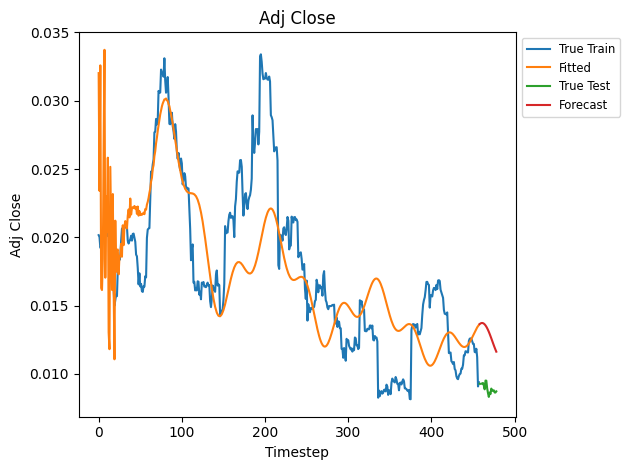

In [28]:
order, test_len = 21, 21
ds = stock_data['Realised Vol'].dropna().to_numpy().reshape(1, -1)
train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=train_data.shape[0], ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.xlabel("Timestep")
plt.ylabel("Adj Close")
plt.title("Adj Close")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

fit_mse = alg.evaluate(train_data, alg.X)
print("Fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print("Forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 16049, CG iterations: 0, optimality: 9.50e-01, constraint violation: 2.22e-16, execution time: 7.9e+01 s.
Fit MSE:  0.3971994041604639
Forecast MSE:  0.03985448113090678


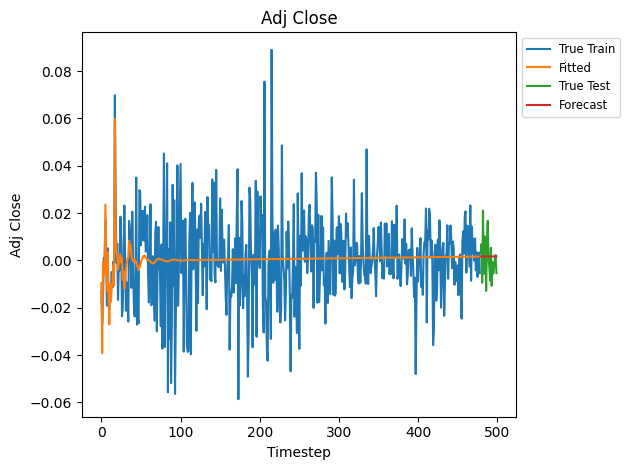

In [29]:
order, test_len = 21, 21
ds = stock_data['Simple Return'].dropna().to_numpy().reshape(1, -1)
train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=train_data.shape[0], ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.xlabel("Timestep")
plt.ylabel("Adj Close")
plt.title("Adj Close")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

fit_mse = alg.evaluate(train_data, alg.X)
print("Fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print("Forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

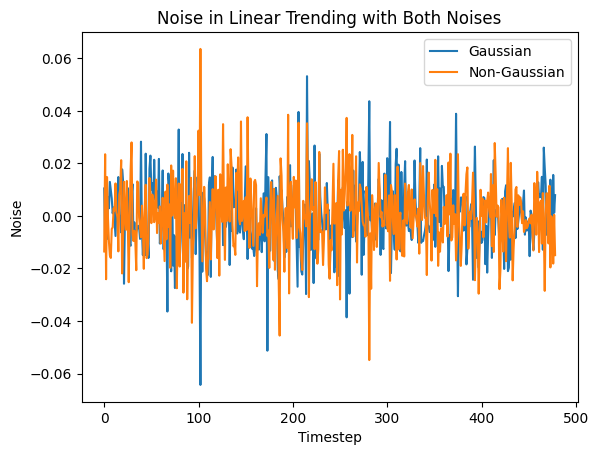

In [31]:
plt.plot(alg.G.T, label="Gaussian")
plt.plot(alg.S.T, label="Non-Gaussian")
plt.title("Noise in Linear Trending with Both Noises")
plt.xlabel("Timestep")
plt.ylabel("Noise")
plt.legend()
plt.show()

In [32]:
order, test_len = 1, 21
ds = stock_data['Simple Return'].dropna().to_numpy().reshape(1, -1)
train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=train_data.shape[0], ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.xlabel("Timestep")
plt.ylabel("Adj Close")
plt.title("Adj Close")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

fit_mse = alg.evaluate(train_data, alg.X)
print("Fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print("Forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

Learning from scratch


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


KeyboardInterrupt: 